I'll summarise here the insights from my brief data analyses and whatever is shared in public discussions.
This is still highly under progress and will be updated when possible.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import random
import datetime

from tqdm import tqdm_notebook as tqdm

# matplotlib and seaborn for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.offline as offline
# offline.init_notebook_mode()

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import preprocessing

import lightgbm as lgb

In [2]:
path = '../input/ashrae-energy-prediction'
# Input data files are available in the "../input/" directory.
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/ashrae-energy-prediction/test.csv
../input/ashrae-energy-prediction/weather_train.csv
../input/ashrae-energy-prediction/train.csv
../input/ashrae-energy-prediction/weather_test.csv
../input/ashrae-energy-prediction/sample_submission.csv
../input/ashrae-energy-prediction/building_metadata.csv


# Load data and display samples

In [3]:
%%time
# unimportant features (see importance below)
unimportant_cols = ['wind_direction', 'wind_speed', 'sea_level_pressure']
target = 'meter_reading'

def load_data(source='train', path=path):
    ''' load and merge all tables '''
    assert source in ['train', 'test']
    
    building = pd.read_csv(f'{path}/building_metadata.csv', dtype={'building_id':np.uint16, 'site_id':np.uint8})
    weather  = pd.read_csv(f'{path}/weather_{source}.csv', parse_dates=['timestamp'],
                                                           dtype={'site_id':np.uint8, 'air_temperature':np.float16,
                                                                  'cloud_coverage':np.float16, 'dew_temperature':np.float16,
                                                                  'precip_depth_1_hr':np.float16},
                                                           usecols=lambda c: c not in unimportant_cols)
    df = pd.read_csv(f'{path}/{source}.csv', dtype={'building_id':np.uint16, 'meter':np.uint8}, parse_dates=['timestamp'])
    df = df.merge(building, on='building_id', how='left')
    df = df.merge(weather, on=['site_id', 'timestamp'], how='left')
    return df

# load and display some samples
train = load_data('train')
train.sample(7)

CPU times: user 22.7 s, sys: 10.6 s, total: 33.3 s
Wall time: 31.2 s


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
11602847,237,1,2016-07-31 09:00:00,54.476,2,Public services,101262,1982.0,NaN,31.703125,NaN,18.906250,0.0
16617934,206,3,2016-10-28 18:00:00,0.000,2,Public services,345837,1966.0,NaN,30.000000,6.0,8.898438,0.0
4970641,1159,2,2016-04-04 09:00:00,36000.000,13,Office,671507,NaN,NaN,-2.199219,NaN,-7.199219,0.0
4392645,92,1,2016-03-24 14:00:00,126.631,0,Office,10779,1970.0,NaN,22.796875,NaN,13.296875,0.0
416999,928,1,2016-01-08 13:00:00,627.406,9,Education,179115,NaN,NaN,7.199219,0.0,6.101562,0.0
5874253,805,0,2016-04-20 11:00:00,3.500,8,Entertainment/public assembly,3200,NaN,1.0,13.898438,NaN,12.796875,0.0
7006413,1155,2,2016-05-10 14:00:00,12.207,13,Warehouse/storage,19059,NaN,NaN,9.398438,NaN,7.800781,5.0


### Test data

In [4]:
test = load_data('test')
test.sample(7)

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
4848649,4848649,226,0,2017-08-05 04:00:00,2,Office,74180,1930.0,NaN,35.593750,4.0,18.906250,0.0
15629034,15629034,741,0,2018-01-21 22:00:00,5,Education,14025,1966.0,1.0,9.000000,NaN,9.000000,NaN
15043583,15043583,732,0,2017-04-22 07:00:00,5,Education,66187,1976.0,1.0,11.000000,NaN,8.000000,NaN
18043906,18043906,793,1,2017-11-08 09:00:00,7,Education,150695,1964.0,6.0,2.300781,NaN,-3.599609,NaN
33001418,33001418,1263,2,2017-05-03 16:00:00,14,Education,97838,NaN,NaN,15.000000,NaN,1.700195,0.0
25289618,25289618,1025,0,2017-08-20 01:00:00,10,Lodging/residential,52034,NaN,2.0,31.093750,0.0,0.000000,0.0
40921823,40921823,1326,0,2018-09-25 15:00:00,15,Office,46981,1962.0,NaN,13.296875,NaN,12.203125,3.0


# EDA and sample statistics

In [5]:
print(f'Training from {train.timestamp.min()} to {train.timestamp.max()}, and predicting from {test.timestamp.min()} to {test.timestamp.max()}')

Training from 2016-01-01 00:00:00 to 2016-12-31 23:00:00, and predicting from 2017-01-01 00:00:00 to 2018-12-31 23:00:00


count    2.021610e+07
mean     2.117121e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

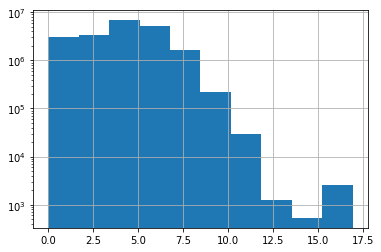

In [6]:
# target's log-log histogram:
ax = np.log1p(train.meter_reading).hist()
ax.set_yscale('log')

# describe raw values first
train.meter_reading.describe()

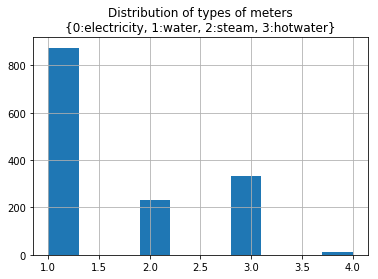

In [7]:
# check the distribution in the types of meters
meters = train.groupby('building_id').meter.nunique()
plt.title('Distribution of types of meters\n{0:electricity, 1:water, 2:steam, 3:hotwater}') # from the official starter kernel
_ = meters.hist()
# from the graphs it looks like steam and hotwater are reversed (e.g.: 3:steam, 2:hotwater) but that shouldn't make any difference to the model

### display a single time series (notice measurement errors and discontinuities)

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


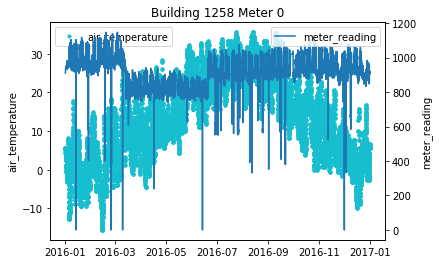

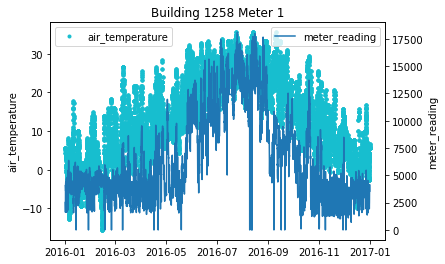

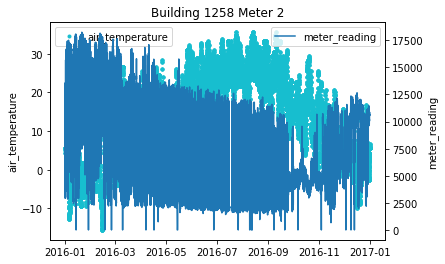

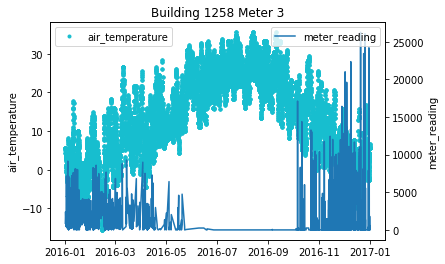

In [8]:
building_id = 1258  # a building with all 4 meters
meters = train[train['building_id'] == building_id].meter.nunique()

for meter in range(meters):
    fig, ax = plt.subplots()
    plt.title(f'Building {building_id} Meter {meter}')
    ax2 = ax.twinx()
    # plot meter_reading
    idx = (train['building_id'] == building_id) & (train['meter'] == meter)
    dates = matplotlib.dates.date2num(train.loc[idx, 'timestamp'])
    ax2.plot_date(dates, train.loc[idx, 'meter_reading'], '-', label='meter_reading')
    # plot air_temperature
    dates = matplotlib.dates.date2num(train.loc[train['building_id'] == building_id, 'timestamp'])
    ax.plot_date(dates, train.loc[train['building_id'] == building_id, 'air_temperature'], '.', color='tab:cyan', label='air_temperature')
    ax.set_ylabel('air_temperature'); ax2.set_ylabel('meter_reading')
    ax.legend(loc='upper left'); ax2.legend(loc='upper right')

### now let's see what's the expected prediction in the test set for the same building

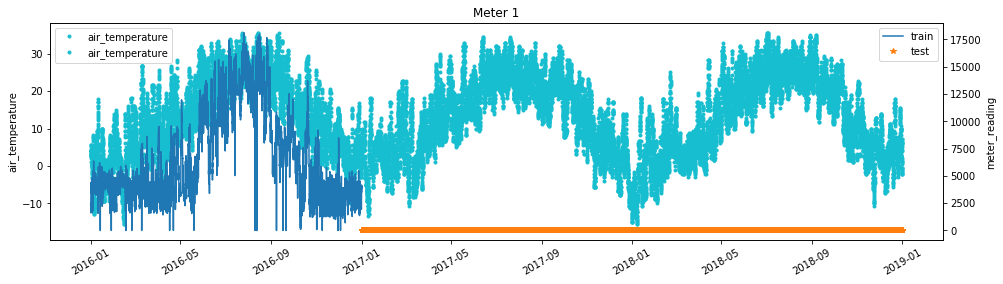

In [9]:
meter = 1 # pick a meter

train_sample = train[(train['building_id'] == building_id) & (train['meter'] == meter)]  # same train sample as above

test['meter_reading'] = 0.0
test_sample = test[(test['building_id'] == building_id) & (test['meter'] == meter)]  # and the same meter in the test set

fig, ax = plt.subplots(figsize=(16,4))
plt.title(f'Meter {meter}')
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax2 = ax.twinx()

# plot training sample
dates = matplotlib.dates.date2num(train_sample['timestamp'])
ax2.plot_date(dates, train_sample['meter_reading'], '-', label='train')
ax.plot_date(dates, train_sample['air_temperature'], '.', color='tab:cyan', label='air_temperature')

# plot test sample
dates = matplotlib.dates.date2num(test_sample['timestamp'])
ax2.plot_date(dates, test_sample['meter_reading'], '*', label='test')
ax.plot_date(dates, test_sample['air_temperature'], '.', color='tab:cyan', label='air_temperature')

ax.set_ylabel('air_temperature'); ax2.set_ylabel('meter_reading')
ax.legend(loc='upper left'); ax2.legend(loc='upper right')

del train_sample; del test_sample; del dates

In [10]:
# some feature stats
train.describe()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,8.088455e+06,3.506933e+06,2.011944e+07,11390735.0,2.011596e+07,16467077.0
mean,7.992780e+02,6.624412e-01,2.117121e+03,7.992232e+00,1.077830e+05,1.968277e+03,4.184848e+00,NaN,NaN,NaN,NaN
std,4.269133e+02,9.309921e-01,1.532356e+05,5.099060e+00,1.171424e+05,3.020815e+01,4.008277e+00,0.000000e+00,0.0,0.000000e+00,NaN
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1.900000e+03,1.000000e+00,-2.890625e+01,0.0,-3.500000e+01,-1.0
25%,3.930000e+02,0.000000e+00,1.830000e+01,3.000000e+00,3.252700e+04,1.951000e+03,1.000000e+00,8.601562e+00,0.0,0.000000e+00,0.0
50%,8.950000e+02,0.000000e+00,7.877500e+01,9.000000e+00,7.270900e+04,1.969000e+03,3.000000e+00,1.670312e+01,0.0,8.898438e+00,0.0
75%,1.179000e+03,1.000000e+00,2.679840e+02,1.300000e+01,1.391130e+05,1.993000e+03,6.000000e+00,2.409375e+01,4.0,1.609375e+01,0.0
max,1.448000e+03,3.000000e+00,2.190470e+07,1.500000e+01,8.750000e+05,2.017000e+03,2.600000e+01,4.718750e+01,9.0,2.609375e+01,343.0


In [11]:
# the counts above expose the missing data (Should we drop or refill the missing data?)
print("Ratio of available data (not NAN's):")
data_ratios = train.count()/len(train)
data_ratios

Ratio of available data (not NAN's):


building_id          1.000000
meter                1.000000
timestamp            1.000000
meter_reading        1.000000
site_id              1.000000
primary_use          1.000000
square_feet          1.000000
year_built           0.400100
floor_count          0.173472
air_temperature      0.995219
cloud_coverage       0.563449
dew_temperature      0.995047
precip_depth_1_hr    0.814553
dtype: float64

In [12]:
# Is the same happening in the test set? Yes
print("Ratio of available data (not NAN's):")
test.count()/len(test)

Ratio of available data (not NAN's):


row_id               1.000000
building_id          1.000000
meter                1.000000
timestamp            1.000000
site_id              1.000000
primary_use          1.000000
square_feet          1.000000
year_built           0.410084
floor_count          0.173950
air_temperature      0.994678
cloud_coverage       0.531336
dew_temperature      0.993745
precip_depth_1_hr    0.812901
meter_reading        1.000000
dtype: float64

In [13]:
# we can refill with averages
train.loc[:, data_ratios < 1.0].mean()

year_built           1968.276736
floor_count             4.184848
air_temperature        15.987972
cloud_coverage          1.900423
dew_temperature         7.747397
precip_depth_1_hr       0.796416
dtype: float64

# Preprocess data

In [14]:
class ASHRAE3Preprocessor(object):
    @classmethod
    def fit(cls, df, data_ratios=data_ratios):
        cls.avgs = df.loc[:,data_ratios < 1.0].mean()
        cls.pu_le = LabelEncoder()
        cls.pu_le.fit(df["primary_use"])

    @classmethod
    def transform(cls, df):
        df = df.fillna(cls.avgs) # refill NAN with averages
        df['primary_use'] = np.uint8(cls.pu_le.transform(df['primary_use']))  # encode labels

        # expand datetime into its components
        df['hour'] = np.uint8(df['timestamp'].dt.hour)
        df['day'] = np.uint8(df['timestamp'].dt.day)
        df['weekday'] = np.uint8(df['timestamp'].dt.weekday)
        df['month'] = np.uint8(df['timestamp'].dt.month)
        df['year'] = np.uint8(df['timestamp'].dt.year-2000)
        
        # parse and cast columns to a smaller type
        df.rename(columns={"square_feet": "log_square_feet"}, inplace=True)
        df['log_square_feet'] = np.float16(np.log(df['log_square_feet']))
        df['year_built'] = np.uint8(df['year_built']-1900)
        df['floor_count'] = np.uint8(df['floor_count'])
        
        # remove redundant columns
        for col in df.columns:
            if col in ['timestamp', 'row_id']:
                del df[col]
    
        # extract target column
        if 'meter_reading' in df.columns:
            df['meter_reading'] = np.log1p(df['meter_reading']).astype(np.float32) # comp metric uses log errors

        return df
        
ASHRAE3Preprocessor.fit(train)

In [15]:
train = ASHRAE3Preprocessor.transform(train)
train.sample(7)

,building_id,meter,meter_reading,site_id,primary_use,log_square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,day,weekday,month,year
7619112,157,0,4.559021,2,6,8.570312,68,4,23.296875,2.000000,5.000000,0.000000,12,21,5,5,16
264396,124,0,3.502550,1,0,10.554688,0,6,8.703125,1.900391,7.800781,0.796387,19,5,1,1,16
8342825,49,0,3.881692,0,4,10.101562,68,4,23.296875,1.900391,21.703125,0.000000,9,3,4,6,16
18957346,1404,0,5.811066,15,4,12.039062,106,4,-3.300781,1.900391,-8.296875,-1.000000,18,9,4,12,16
17534588,912,2,0.000000,9,0,10.867188,68,4,19.406250,2.000000,13.898438,0.000000,1,14,0,11,16
20210055,806,0,4.119037,8,7,10.265625,68,2,23.296875,1.900391,10.000000,0.000000,21,31,5,12,16
3330910,997,1,4.715280,9,6,10.546875,68,4,20.000000,1.900391,17.203125,0.000000,12,3,3,3,16


In [16]:
train.dtypes

building_id           uint16
meter                  uint8
meter_reading        float32
site_id                uint8
primary_use            uint8
log_square_feet      float16
year_built             uint8
floor_count            uint8
air_temperature      float16
cloud_coverage       float16
dew_temperature      float16
precip_depth_1_hr    float16
hour                   uint8
day                    uint8
weekday                uint8
month                  uint8
year                   uint8
dtype: object

# Feature ranked correlation

CPU times: user 11 s, sys: 1.26 s, total: 12.2 s
Wall time: 11.4 s


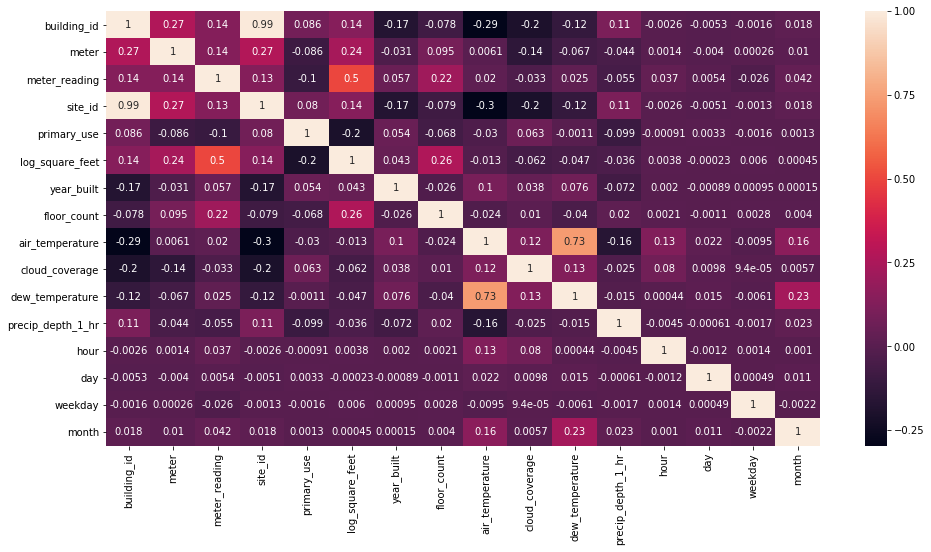

In [17]:
%%time
fig, ax = plt.subplots(figsize=(16,8))
# use a ranked correlation to catch nonlinearities
corr = train[[col for col in train.columns if col != 'year']].sample(250000).corr(method='spearman')
_ = sns.heatmap(corr, annot=True,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

# Train K folds

In [18]:
# force the model to use the weather data instead of dates, to avoid overfitting to the past history
features = [col for col in train.columns if col not in [target, 'year', 'month', 'day']]

In [19]:
folds = 4
seed = 42
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
# oof_pred = np.zeros(train.shape[0])  # out of fold predictions
models = []

## stratify data by building_id
for tr_idx, val_idx in tqdm(kf.split(train, train['building_id']), total=folds):
    def fit_regressor(tr_idx, val_idx):
        tr_x, tr_y = train[features].iloc[tr_idx], train[target][tr_idx]
        vl_x, vl_y = train[features].iloc[val_idx], train[target][val_idx]
        print({'train size':len(tr_x), 'eval size':len(vl_x)})

        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)  
        clf = lgb.LGBMRegressor(n_estimators=6000,
                                learning_rate=0.25,
                                feature_fraction=0.9,
                                subsample=0.2,  # batches of 20% of the data
                                subsample_freq=1,
                                num_leaves=20,
                                metric='rmse')
        clf.fit(tr_x, tr_y,
                eval_set=[(vl_x, vl_y)],
                early_stopping_rounds=50,
                verbose=200)
#         oof_pred[val_idx] += clf.predict(vl_x, num_iteration=clf.best_iteration_)
        return clf
    clf = fit_regressor(tr_idx, val_idx)
    models.append(clf)
#     break ### TODO: remove to run next folds
    
gc.collect()

{'train size': 15161663, 'eval size': 5054437}
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 1.197
[400]	valid_0's rmse: 1.10693
[600]	valid_0's rmse: 1.05789
[800]	valid_0's rmse: 1.03026
[1000]	valid_0's rmse: 1.0104
[1200]	valid_0's rmse: 0.994618
[1400]	valid_0's rmse: 0.981353
[1600]	valid_0's rmse: 0.970457
[1800]	valid_0's rmse: 0.961823
[2000]	valid_0's rmse: 0.954751
[2200]	valid_0's rmse: 0.947124
[2400]	valid_0's rmse: 0.941044
[2600]	valid_0's rmse: 0.936618
[2800]	valid_0's rmse: 0.931746
[3000]	valid_0's rmse: 0.926605
[3200]	valid_0's rmse: 0.922658
[3400]	valid_0's rmse: 0.919099
[3600]	valid_0's rmse: 0.915749
[3800]	valid_0's rmse: 0.912798
[4000]	valid_0's rmse: 0.910128
[4200]	valid_0's rmse: 0.907456
[4400]	valid_0's rmse: 0.905245
[4600]	valid_0's rmse: 0.903127
[4800]	valid_0's rmse: 0.900823
[5000]	valid_0's rmse: 0.898325
[5200]	valid_0's rmse: 0.896623
[5400]	valid_0's rmse: 0.894652
[5600]	valid_0's rmse: 0.892942
[5800]	

316

# Feature importance

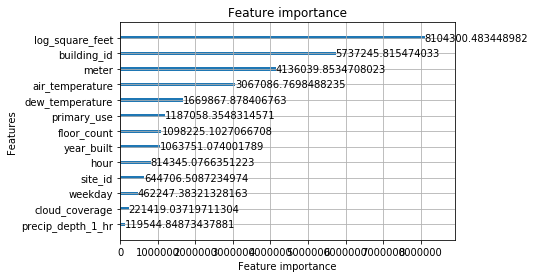

In [20]:
_ = lgb.plot_importance(models[0], importance_type='gain')

In [21]:
# calculate the mean feature importance, so that we can update 'unimportant_cols' above
feature_importance = np.mean([m._Booster.feature_importance(importance_type='gain') for m in models], axis=0)
sorted(zip(feature_importance, train.columns), reverse=True)

[(8109649.915606439, 'primary_use'),
 (5646706.830129087, 'building_id'),
 (4175752.405502498, 'meter'),
 (2998884.912564099, 'floor_count'),
 (1717589.935952425, 'cloud_coverage'),
 (1139065.8840931058, 'site_id'),
 (1123000.1064486504, 'year_built'),
 (1038825.8887557983, 'log_square_feet'),
 (837138.7459225655, 'precip_depth_1_hr'),
 (735686.8913545012, 'meter_reading'),
 (467064.2392154336, 'hour'),
 (233590.39624798298, 'air_temperature'),
 (120785.62956011295, 'dew_temperature')]

# Check prediction

In [22]:
# load and pre-process test data
test = ASHRAE3Preprocessor.transform(test)
test.sample(7)

,building_id,meter,site_id,primary_use,log_square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,meter_reading,hour,day,weekday,month,year
35799471,1311,1,14,4,11.109375,68,4,15.000000,0.000000,11.101562,0.0,0.0,12,12,1,6,18
33494562,1296,1,14,6,9.085938,68,4,23.906250,1.900391,22.796875,43.0,0.0,0,14,4,7,17
22298053,915,2,9,0,12.234375,68,4,11.703125,1.900391,4.398438,0.0,0.0,1,26,1,12,17
21722346,992,0,9,6,10.851562,68,4,20.593750,0.000000,15.000000,0.0,0.0,13,8,6,10,17
7466159,243,0,2,8,13.234375,104,4,29.406250,1.900391,21.093750,0.0,0.0,13,17,4,8,18
26867770,1130,0,13,0,12.546875,68,4,-1.099609,1.900391,-3.300781,0.0,0.0,4,18,2,1,17
24161758,995,1,9,0,10.742188,68,4,27.796875,1.900391,22.796875,0.0,0.0,15,6,3,9,18


### now let's revisit the same meter we had initially looked at, and check the predictions for each fold

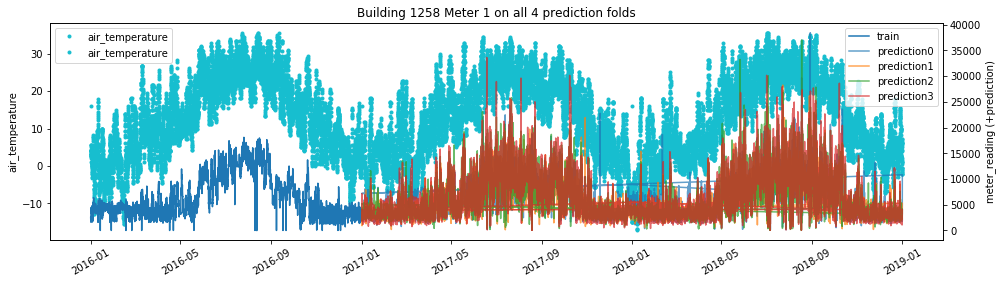

In [23]:
def recover_timestamp(x):
    ''' reassemble timestamp using date components '''
    return datetime.datetime.strptime(f'{x.year}-{x.month}-{x.day} {x.hour}', '%y-%m-%d %H')

fig, ax = plt.subplots(figsize=(16,4))
plt.title(f'Building {building_id} Meter {meter} on all {folds} prediction folds')
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax2 = ax.twinx()

train_sample = train[(train['building_id'] == building_id) & (train['meter'] == meter)]  # same training sample as before
test_sample = test[(test['building_id'] == building_id) & (test['meter'] == meter)]   # and the same meter in the test set

# plot training sample
dates = matplotlib.dates.date2num(train_sample[['year', 'month', 'day', 'hour']].apply(recover_timestamp, axis=1))
ax.plot_date(dates, train_sample['air_temperature'], '.', color='tab:cyan', label='air_temperature')
ax2.plot_date(dates, np.expm1(train_sample['meter_reading']), '-', color='tab:blue', label='train')

# plot prediction sample
dates = matplotlib.dates.date2num(test_sample[['year', 'month', 'day', 'hour']].apply(recover_timestamp, axis=1))
ax.plot_date(dates, test_sample['air_temperature'], '.', color='tab:cyan', label='air_temperature')
for i,model in enumerate(models):
    ax2.plot_date(dates, np.expm1(model.predict(test_sample[features])), '-', label=f'prediction{i}', alpha=0.7)

ax.set_ylabel('air_temperature'); ax2.set_ylabel('meter_reading (+prediction)')
ax.legend(loc='upper left'); ax2.legend(loc='upper right')
_ = plt.show()

del test_sample; del train_sample
_ = gc.collect()

In [24]:
# # Check if all test buildings and meters are the same as in the training data
# train_buildings = np.unique(train[['building_id', 'meter']].values, axis=0)
# # del train; gc.collect()

# test_buildings  = np.unique(test[['building_id', 'meter']].values, axis=0)

# print(len(train_buildings), len(test_buildings))
# [b for b in test_buildings if b not in train_buildings]

# Test Inference and Submission

In [25]:
# split test data into batches
set_size = len(test)
iterations = 50
batch_size = set_size // iterations

print(set_size, iterations, batch_size)
assert set_size == iterations * batch_size

41697600 50 833952


In [26]:
meter_reading = []
for i in tqdm(range(iterations)):
    pos = i*batch_size
    fold_preds = [np.expm1(model.predict(test[features].iloc[pos : pos+batch_size])) for model in models]
    meter_reading.extend(np.mean(fold_preds, axis=0))

print(len(meter_reading))
assert len(meter_reading) == set_size


41697600


### Save submission

In [27]:
submission = pd.read_csv(f'{path}/sample_submission.csv')
submission['meter_reading'] = np.clip(meter_reading, a_min=0, a_max=None) # clip min at zero

In [28]:
submission.to_csv('submission.csv', index=False)
submission.head(9)

,row_id,meter_reading
0,0,2.132380
1,1,1.724892
2,2,0.000000
3,3,3.040610
4,4,8.122018
5,5,0.194021
6,6,1.942152
7,7,6.336599
8,8,2.275866


count    4.169760e+07
mean     4.943268e+02
std      1.597906e+04
min      0.000000e+00
25%      1.867444e+01
50%      6.917017e+01
75%      2.203714e+02
max      1.630771e+07
Name: meter_reading, dtype: float64

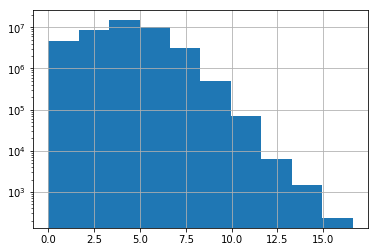

In [29]:
# prediction's log-log histogram:
plt.yscale('log')
_ = np.log1p(submission['meter_reading']).hist()

# describe raw submission
submission['meter_reading'].describe()